<a href="https://colab.research.google.com/github/cheikhAbd/Sentiment_Analysis_Arabic/blob/main/Sentiment_Analysis_Arabic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## **Définition d'une variable d'environnement kaggle**

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

## **Installation du dataset**

In [ ]:
!pip install --upgrade xlrd

In [ ]:
!kaggle competitions download -c arabic-sentiment-analysis-2021-kaust

In [ ]:
!unzip /content/2.Egyptian\ Tweets.xlsx.zip -d /content/

## **Importation du Bibliotheque necessaire**

In [ ]:
import pickle
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import sys

%matplotlib inline


In [ ]:

## Dataframe pour l'entraînement
df_train_neg = pd.read_csv('/content/train_Arabic_tweets_negative_20190413.tsv', sep='\t')
df_train_pos = pd.read_csv('/content/train_Arabic_tweets_positive_20190413.tsv', sep='\t')

# dataframe pour la test
df_test_neg = pd.read_csv('/content/test_Arabic_tweets_negative_20190413.tsv', sep='\t')
df_test_pos = pd.read_csv('/content/test_Arabic_tweets_positive_20190413.tsv', sep='\t')

# mais le dataframe dans meme data entraînement
df_train = pd.concat([df_train_neg, df_train_pos], axis=0)

# mais le dataframe dans meme data test
df_test = pd.concat([df_test_neg, df_test_pos], axis=0)

# le coordonnée pour entraînement
X_train = df_train['text'].values
Y_train = df_train['sentiment'].astype('category').cat.codes.values

# le coordonnée pour test
X_test = df_train['text'].values
Y_test = df_train['sentiment'].astype('category').cat.codes.values

Y_train.shape , X_train.shape , X_test.shape , Y_test.shape

((45275,), (45275,), (45275,), (45275,))

In [ ]:
X_train.shape

(45275,)

In [ ]:
Y_train

array([0, 0, 0, ..., 1, 1, 1], dtype=int8)

## **convertir les données textuelles en données numériques**

In [ ]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train.astype('U'))
X_test = vectorizer.fit_transform(X_test.astype('U'))


In [ ]:
X_train

<45275x70856 sparse matrix of type '<class 'numpy.float64'>'
	with 487603 stored elements in Compressed Sparse Row format>

## **Entraîner le modèle**

In [ ]:
model = LogisticRegression(max_iter=1000)

In [ ]:
model.fit(X_train,Y_train)

LogisticRegression(max_iter=1000)

## **Évaluation du modèle**

## **Score de précision**

In [ ]:
# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train,X_train_prediction)

In [ ]:
print(training_data_accuracy)

0.8902484815019326


In [ ]:
# accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test,X_test_prediction)

In [ ]:
print(test_data_accuracy)

0.8902484815019326


## **Enregistrer le modèle de formation**

In [ ]:
pickle.dump(model,open('trained_model.sav','wb'))

In [ ]:
pickle.dump(vectorizer, open('vectorizer.sav', 'wb'))

## **Utiliser le modèle enregistré pour les prédictions futures**

In [ ]:
# loading the saving model
load_model = pickle.load(open('/content/trained_model.sav','rb'))

In [ ]:
X_new = X_test[30000]
print(X_test[30000])

pred = model.predict(X_new)
print(pred)

if (pred[0] == 0):
  print('neg tweet')
else :
  print('pos tweet')

  (0, 10615)	0.2599802670186826
  (0, 20618)	0.2599802670186826
  (0, 50735)	0.2599802670186826
  (0, 51491)	0.2599802670186826
  (0, 58475)	0.2599802670186826
  (0, 15721)	0.2599802670186826
  (0, 18472)	0.2599802670186826
  (0, 48961)	0.25800517100484244
  (0, 32404)	0.23816207411928386
  (0, 22238)	0.23215829175980549
  (0, 41460)	0.2561575920725456
  (0, 67960)	0.21647139830142845
  (0, 28377)	0.2337491197560908
  (0, 11454)	0.24976954169551238
  (0, 9524)	0.21390602287053218
  (0, 14643)	0.12682684693576707
  (0, 65426)	0.11347695444384656
  (0, 50505)	0.14856703559760495
  (0, 51925)	0.15295894512846056
[1]
pos tweet


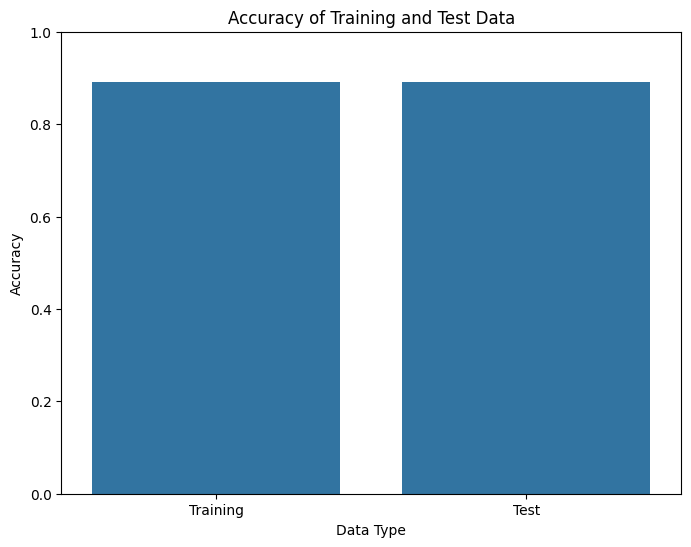

In [ ]:
# Précisions des données
data = {
    'Type': ['Training', 'Test'],
    'Accuracy': [training_data_accuracy, test_data_accuracy]
}

# Création d'un DataFrame pour faciliter la visualisation
df_accuracy = pd.DataFrame(data)

# Visualisation
plt.figure(figsize=(8, 6))
sns.barplot(x='Type', y='Accuracy', data=df_accuracy)
plt.title('Accuracy of Training and Test Data')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Data Type')
plt.show()

In [ ]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords.words('arabic')

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'